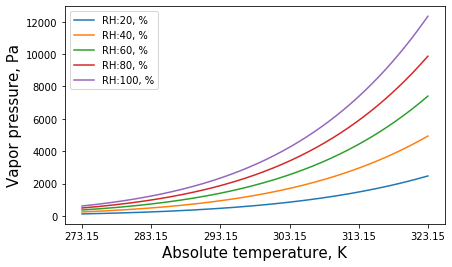

In [1]:
import nbimporter
import numpy as np
import matplotlib.pyplot as plt
import vapour_pressure as vp

### Goranの測定したConcrete（コンクリート）の物性値  
参考：Goran?  
建築材料の熱・空気・湿気物性値

$\psi$：空隙率(porosity)[-]  

In [2]:
def psi():
    return 0.392

$C$：材料の比熱(specific heat)[J/(kg・K)]  

In [3]:
def C():
    return 1100.0

$\rho$：材料の密度(density)[kg/m3]

In [4]:
def row():
    return 2303.2

$\rho_w$：水の密度(moisture density)[kg/m3]

In [5]:
def roww():
    return 1000.0

$C_r$：水の比熱(specific heat of water)[J/(kg・K)]

In [6]:
def Cr():
    return 4.18605E+3

#### 熱容量

In [7]:
def get_crow( water ):
    return C() * row() + water.crow * water.phi

## Functions

#### 水分の状態を格納するクラスの例

In [8]:
class Water_Info():
    def __init__(self):
        self.crow = roww() + Cr()    
    def set_temp( self, initial = 0.0 ):
        self.temp = initial 
    def set_RH( self, initial = 0.0 ):
        self.rh = initial  
    def set_miu( self, initial = 0.0 ):
        self.miu = initial  
    def set_pv( self, initial = 0.0 ):
        self.pv = initial 
    def set_phi( self, initial = 0.0 ):
        self.phi = initial 

#### 熱伝導率

In [9]:
def get_lam( water ):
    return 1.3 + 3.5 * get_phi( water )

#### 平衡含水率

In [10]:
def get_phi( water ):
    if water.miu > - 1.0e-3 :
        phi = 0.24120 * water.miu + 0.159720
    elif np.log10( -water.miu ) < 3.7680:
        phi = 0.16390 + 0.035180 / ( np.log10(-water.miu) - 4.95930 )
    elif np.log10( -water.miu ) < 5.2980:
        phi = -3.0654540 + 2.2674670 * np.log10( -water.miu ) \
        -5.208352e-1 * np.log10( -water.miu ) ** 2.0 + 3.833344e-2 * np.log10( -water.miu ) ** 3.0
    elif np.log10( -water.miu ) < 10.16940:
        phi = -0.00980 + 0.063950 / ( np.log10( -water.miu ) - 3.64410 )
    else:
        phi = 0.0
    return phi

#### 含水率から水分化学ポテンシャル

In [11]:
def get_miu_by_phi( water ):
    PHI1 = 0.159470
    PHI0 = 0.13430
      
    if water.phi > PHI1:
        miu = - 1.0e-3
    elif PHI1 >= water.phi and water.phi >= PHI0 :
        miu = ( -1.0 ) * 10.0 ** ( 4.95930 + 0.035180 / ( water.phi - 0.16390 ) )
    else: 
        miu = ( -1.0 ) * 10.0 ** ( 3.7680 )
    return miu

#### 水分化学ポテンシャル勾配に対する液相水分伝導率$\lambda^{'}_{\mu l}$

In [12]:
def get_ldml( water ):
    return np.exp( - 75.102120 + 350.0070 * get_phi( water ) )

#### 温度勾配に対する気相水分伝導率$\lambda^{'}_{T g}$

In [13]:
def get_ldtg( water ):
    DPVS  = vp.DPvs( water.temp )
    DPVSS = vp.DPvs( 293.16 )
    phi = get_phi( water )
    
    if   phi < 0.0000010:
        LDTG  = 0.0
    elif phi < 0.032964 :
        FTLDT = -9.87290 - 0.0101010 / phi
    elif phi < 0.1278 :
        FTLDT = -10.489310 + 10.38831 * phi - 56.457320 * phi ** 2.0 + 806.5875 * phi ** 3.0
    else:
        FTLDT = - 8063.50 * ( phi - 0.1300 ) ** 2.0 - 8.3610
      
    if phi < 0.00001:
        LDTG=0.0
    else:
        FTLDT  = FTLDT
        LDTG = 10.0 ** FTLDT * DPVS / DPVSS
        
    return LDTG

#### 水分化学ポテンシャル勾配に対する気相水分伝導率$\lambda^{'}_{\mu g}$

In [14]:
def get_ldmg( water ):
    RV = 8316.960 / 18.0160
    LDTG = get_ldtg( water )
    dpvs = vp.DPvs( water.temp )
    pvs  = vp.Pvs ( water.temp )
    return LDTG / ( RV * water.temp * dpvs / pvs - water.miu / water.temp )

#### 含水率の水分化学ポテンシャル微分

In [15]:
def get_dphi( water ):
    if   water.miu > -1.0e-3:
        dphi = 0.24120
    elif np.log10( -water.miu ) < 3.7680:
        dphi = -0.035180 / ( np.log10( -water.miu ) - 4.95930 )  \
                / ( np.log10( -water.miu ) - 4.95930 ) / water.miu / np.log( 10.0 )
    elif np.log10( -water.miu ) < 5.2980:
        dphi = ( 2.2674670 - 1.04167040 * np.log10( -water.miu ) \
                + 1.1500032e-1 * np.log10( -water.miu ) ** 2.0) / water.miu / np.log( 10.0 )
    elif np.log10( -water.miu ) < 10.16940:
        dphi = -0.063950 / ( np.log10( -water.miu ) -3.64410 )  \
                / ( np.log10( -water.miu ) - 3.64410 ) / water.miu / np.log( 10.0 )
    else:
        dphi = 0.0
    return dphi

### Example

In [16]:
water = Water_Info()
water.set_temp( 293.15 ) 
water.set_miu( -10.0 ) 
water.set_phi( 0.30 )

In [17]:
get_crow( water )

2535075.815

In [18]:
get_lam( water )

1.8425510683706716

In [19]:
get_phi( water )

0.155014590963049

In [20]:
get_miu_by_phi( water )

-0.001

In [21]:
get_ldml( water )

8.845623961863231e-10

In [22]:
get_ldtg( water )

3.9191568164576734e-14

In [23]:
get_ldmg( water )

4.675339581854365e-18

In [24]:
get_dphi( water )

9.74637969893945e-05

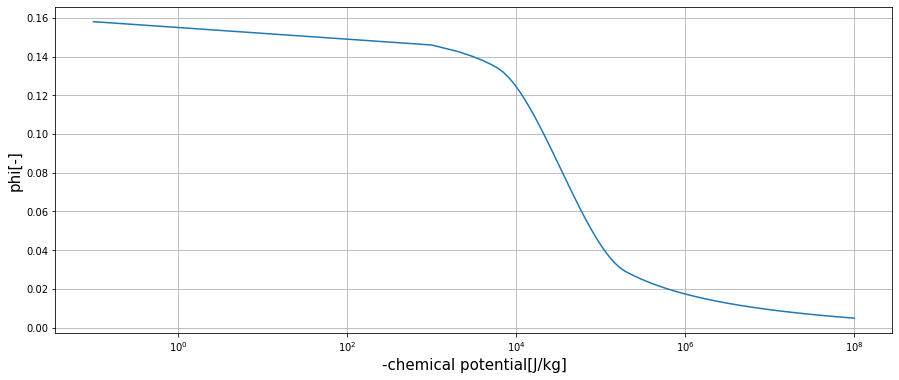

In [25]:
#######################################
###     物性値の確認     ###
###     グラフの描画      ###
plt.figure(figsize = (15.0, 6))
plt.xscale("log")
#plt.yscale("log")
plt.grid(which="both")
plt.xlabel("-chemical potential[J/kg]", fontsize = 15)
plt.ylabel("phi[-]", fontsize = 15)

L = 100000
b = [ Water_Info() for i in range( L )] 
[ b[i].set_miu( -1000 * i - 0.1 ) for i in range ( L ) ]
[ b[i].set_temp( 293.15 ) for i in range ( L ) ]
miu = [ -b[i].miu for i in range( L ) ]
phi = [ get_phi( b[i] ) for i in range ( L ) ]
plt.plot( miu, phi )
plt.show()
###########################